In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

%pylab inline
data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

def numeric(self):
    '''Monkey-patches numeric features'''
    return self.select_dtypes(include=[np.number])
pd.DataFrame.numeric = numeric

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('data_cleaned.csv')
for i in data.columns:
    if 'Unn' in i: del data[i]
country = data.pop('country')

In [3]:
# Take the reliable data
print(len(data), 'records remaining')
data = data[data['i_have_answered_all_of_these_questions_as_accurately_as_possible'] == 7]
data = data[data['i_understand_the_instructions_for_this_test'] == 7]

# Remove unreliable data based on questions with highest correlations
print(len(data), 'records remaining')
data['reliable'] = np.where(
    np.abs(data['i_see_myself_as_an_average_person'] - data['i_consider_myself_an_average_person']) <= 2, 1, 0)

data = data[data.reliable == 1]
print(len(data), 'records remaining')

data['reliable'] = np.where(
    np.abs(data['i_say_little'] - data['i_dont_talk_a_lot']) <= 2, 1, 0)

data = data[data.reliable == 1]
print(len(data), 'records remaining')

del data['reliable']

22786 records remaining
13097 records remaining
12391 records remaining
11710 records remaining


In [4]:
# Transpose the dataframe, so we're analyzing questions instead of users
qs = data.select_dtypes(include=[np.number]).fillna(data.mean()).T

qs['stdev'] = qs.std(axis=1)

questions_sorted = qs.sort_values('stdev', ascending=False)['stdev'].index

# Most controversial at top; least controversial at bottom
# questions_sorted

In [5]:
from collections import defaultdict

def absolute_correlations(col, df=data, threshold=.5):
    '''Finds related questions, with both positive and negative correlations'''
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs[corrs.absol > threshold].sort_values('absol', ascending=False).drop('absol', axis=1)

def rev(item):
    '''Questions are scored out of 7, and many need to be reverse-scored'''
    return 8 - item

In [6]:
# Record which questions go in each factor
factors = defaultdict(list)

# Use each question only once
questions_used = []

# Put users' scores in a dataframe
df_factors = pd.DataFrame()

for question in questions_sorted:
    if question not in questions_used:
        related = absolute_correlations(
            question,
            df=data[[i for i in data.columns if i not in questions_used]],
            threshold=.5
        )        
        if len(related) >= 4:
            for related_question in related.index:
                questions_used.append(related_question)
            factors[question].append(related.index)
            
            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)   

            df_factors[question] = (data[pos_items].sum(axis=1) + (8-data[neg_items]).sum(axis=1))/(.07*len(all_items))
            
print('found', str(df_factors.shape[1]), 'personality traits')

found 15 personality traits


In [7]:
df_factors

,i_seem_to_derive_less_enjoyment_from_interacting_with_people_than_others_do,i_dont_talk_a_lot,i_find_that_it_takes_a_lot_to_make_me_feel_angry_at_someone,i_am_a_physical_coward,i_am_just_an_ordinary_person,i_would_never_take_things_that_arent_mine,i_often_forget_to_put_things_back_in_their_proper_place,i_get_stressed_out_easily,i_find_it_hard_to_forgive_others,i_tire_out_quickly,i_put_on_a_show_to_impress_people,i_make_rash_decisions,i_continue_until_everything_is_perfect,i_work_hard,i_come_up_with_something_new
1,67.857143,57.142857,62.500000,57.142857,21.428571,42.857143,67.857143,71.428571,82.142857,64.285714,78.571429,53.571429,71.428571,32.142857,85.714286
3,57.142857,66.071429,35.714286,82.142857,39.285714,46.428571,71.428571,85.714286,53.571429,75.000000,67.857143,75.000000,64.285714,42.857143,60.714286
5,62.500000,67.857143,37.500000,57.142857,82.142857,46.428571,100.000000,88.095238,60.714286,89.285714,85.714286,71.428571,57.142857,42.857143,82.142857
6,17.857143,16.071429,42.857143,53.571429,53.571429,92.857143,60.714286,80.952381,46.428571,39.285714,78.571429,92.857143,57.142857,67.857143,60.714286
8,69.642857,58.928571,60.714286,67.857143,71.428571,92.857143,32.142857,35.714286,89.285714,85.714286,42.857143,32.142857,71.428571,67.857143,85.714286
9,46.428571,32.142857,41.071429,39.285714,60.714286,89.285714,46.428571,64.285714,57.142857,35.714286,57.142857,75.000000,71.428571,60.714286,71.428571
16,42.857143,37.500000,48.214286,46.428571,17.857143,82.142857,39.285714,54.761905,42.857143,71.428571,32.142857,50.000000,46.428571,28.571429,89.285714
22,58.928571,44.642857,28.571429,75.000000,67.857143,75.000000,89.285714,59.523810,25.000000,85.714286,50.000000,85.714286,42.857143,25.000000,75.000000
28,33.928571,39.285714,46.428571,39.285714,71.428571,82.142857,50.000000,66.666667,71.428571,71.428571,35.714286,67.857143,60.714286,82.142857,92.857143
29,78.571429,67.857143,73.214286,39.285714,21.428571,85.714286,75.000000,66.666667,78.571429,82.142857,50.000000,39.285714,82.142857,75.000000,100.000000


In [8]:
from sklearn.decomposition import FactorAnalysis

for n in range(50,2,-1):
    data = data.select_dtypes(include=[np.number])
    factor = FactorAnalysis(n_components=n, random_state=1).fit(data)

    # Stick it in a dataframe
    factors = pd.DataFrame(factor.components_, columns=data.columns).T

    col_names = []
    for i in range(n):
        # We'll need non-zero factor values for our next
        # step, so we'll start counting at 1
        col_names.append('factor_' + str(i + 1))

    factors.columns = col_names

    data_new = pd.DataFrame()
    items = []
    for i in col_names:
        for k, v in zip(factors[i].index, factors[i]):
            if np.abs(v) > 0.2: # factor loading
                items.append((i,k,v))
    
    # This effectively counts the number of items in
    # each factor. 4 or more should make the factor reliable. 
    items = pd.DataFrame(items)
    group = items.groupby(0).count()
    if len(group[group >= 4].dropna()) == n:
        print(n, 'works!')
        break

# OFA

In [9]:
def uncorrelated(col, df=data, threshold=100):
    '''Similar to absolute_correlations, but now finds uncorrelated items'''
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    
    # Default is to return all items sorted by correlation (ascending)
    return corrs[corrs.absol < threshold].sort_values('absol', ascending=True).drop('absol', axis=1)

In [10]:
from collections import defaultdict

# Record which questions go in each factor
factors = defaultdict(list)

# We're no longer going to worry if a question has been used
# We're now more interested in validity and reliability than style!
questions_used = []

# Put users' scores in a dataframe
df_factors = pd.DataFrame()

th = 0.55
lenrel = 3

# Seed the dataframe with the first reliable trait
for question in questions_sorted:
    related = absolute_correlations(
        question,
        df=data,
        threshold=th
    )        
    if len(related) >= lenrel:
        #for related_question in related.index:
            #questions_used.append(related_question)
        factors[question].append(related.index)

        pos_items = related[related['correlation'] > 0].index
        neg_items = related[related['correlation'] < 0].index
        all_items = list(pos_items) + list(neg_items)   

        df_factors[question] = (data[pos_items].sum(axis=1) + (8-data[neg_items]).sum(axis=1))/(.07*len(all_items))
        break

# So far, so good
df_factors.head()

,i_rarely_cry_during_sad_movies
1,42.857143
3,66.666667
5,33.333333
6,42.857143
8,52.380952


In [11]:
corr = 0

# Run this until we find a trait that correlates more than 0.7 with an existing one
while corr < .50:
    next_q = data.corrwith(df_factors[df_factors.columns[-1]])
    candidates = pd.DataFrame()
    for i in np.abs(next_q).sort_values().index:
        related = absolute_correlations(
            i,
            df=data,
            threshold=th)        
        if len(related) >= lenrel:
            #for related_question in related.index:
                #questions_used.append(related_question)

            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)
            candidates[i] = (data[pos_items].sum(axis=1) + (8-data[neg_items]).sum(axis=1))/(.07*len(all_items))

    candidates_scores = {}
    for i in candidates.columns:
        candidates_scores[i] = np.abs(df_factors.corrwith(candidates[i])).max()

    candidates_scores = pd.DataFrame([candidates_scores]).T.sort_values(0)

    print('Using:', pd.DataFrame(candidates_scores).index[0])
    
    corr = candidates_scores.get_value(candidates_scores.index[0], 0)
    print(round(corr, 2))
    
    next_q = data.corrwith(df_factors[df_factors.columns[-1]])
    candidates = pd.DataFrame()
    for i in candidates_scores.index:
        related = absolute_correlations(
            i,
            df=data, threshold=th)        
        if len(related) >= lenrel:
            #for related_question in related.index:
                #questions_used.append(related_question)
            factors[i].append(related.index)

            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)
            df_factors[i] = (data[pos_items].sum(axis=1) + (8-data[neg_items]).sum(axis=1))/(.07*len(all_items))    
            break
    if i == candidates_scores.index[-1]:
        raise Exception('Could not find any more traits')
    
    print()

Using: i_pay_attention_to_details
0.0

Using: i_like_to_be_thought_of_as_a_normal_kind_of_person
0.05

Using: i_talk_to_a_lot_of_different_people_at_parties
0.08

Using: i_am_easily_annoyed
0.13

Using: i_have_a_vivid_imagination
0.18

Using: i_would_feel_very_badly_for_a_long_time_if_i_were_to_steal_from_someone
0.19

Using: i_leave_a_mess_in_my_room
0.24

Using: i_begin_to_panic_when_there_is_danger
0.27

Using: i_have_a_strong_need_for_power
0.28

Using: i_work_hard
0.32

Using: i_jump_into_things_without_thinking
0.36

Using: i_am_inclined_to_forgive_others
0.46

Using: i_feel_healthy_and_vibrant_most_of_the_time
0.5



In [12]:
for num, top in enumerate(factors):
    print(str(num+1)+'. ' + top)
    for list_ in factors[top]:
        for question in list_:
            print('-', question)
    print()

1. i_rarely_cry_during_sad_movies
- i_rarely_cry_during_sad_movies
- i_cry_during_movies
- i_seldom_feel_weepy_while_reading_the_sad_part_of_a_story

2. i_pay_attention_to_details
- i_pay_attention_to_details
- i_have_an_eye_for_detail
- i_pay_too_little_attention_to_details

3. i_like_to_be_thought_of_as_a_normal_kind_of_person
- i_like_to_be_thought_of_as_a_normal_kind_of_person
- i_enjoy_being_thought_of_as_a_normal_mainstream_person
- i_am_just_an_ordinary_person

4. i_talk_to_a_lot_of_different_people_at_parties
- i_talk_to_a_lot_of_different_people_at_parties
- i_am_the_life_of_the_party
- i_make_friends_easily

5. i_am_easily_annoyed
- i_am_easily_annoyed
- i_get_irritated_easily
- i_get_angry_easily
- i_rarely_get_irritated
- i_lose_my_temper
- i_rarely_feel_angry_with_people
- i_seldom_get_mad
- i_find_that_it_takes_a_lot_to_make_me_feel_angry_at_someone

6. i_have_a_vivid_imagination
- i_have_a_vivid_imagination
- i_do_not_have_a_good_imagination
- i_have_difficulty_imagining

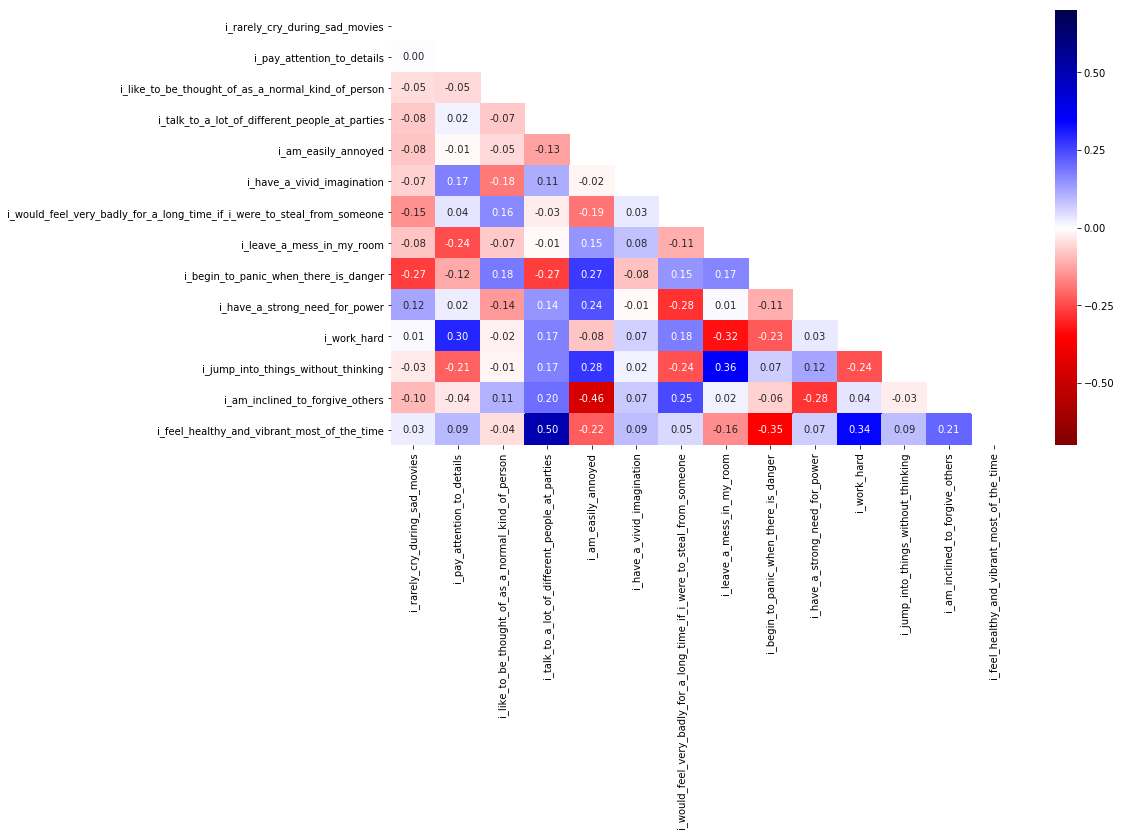

In [13]:
# Generate a mask for the upper triangle
mask = np.zeros_like(df_factors.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Resize and display
plt.figure(figsize=(14,8))
sns.heatmap(df_factors.corr(), annot=True, 
            vmax=.7, vmin=-.7, fmt='.2f', mask=mask, cmap='seismic_r')

# Central Factor: The Big One?

I was thinking about how intelligence has a single factor *g* that predicts success in nearly every domain of life.

What if we looked at a single factor in terms of personality? What would it be and what would we call it?

In [16]:
from sklearn.decomposition import FactorAnalysis

qs = data.drop(['i_understand_the_instructions_for_this_test',
       'i_have_answered_all_of_these_questions_as_accurately_as_possible',
       'time_elapsed'], axis=1).T

fa = FactorAnalysis(n_components=1).fit(qs)

In [17]:
loadings = pd.DataFrame(fa.transform(qs))

loadings.index = qs.index

In [18]:
loadings['absol'] = np.abs(loadings[0])

loadings.sort_values('absol', ascending=False).drop('absol', axis=1).head(30)

,0
i_do_not_like_art,2.879309
i_cheat_on_people_who_have_trusted_me,2.623840
i_do_not_have_a_good_imagination,2.603450
i_have_difficulty_imagining_things,2.583800
i_have_a_vivid_imagination,-2.239702
i_believe_in_the_importance_of_art,-2.211958
i_steal_things,2.181350
i_avoid_difficult_reading_material,2.149100
i_get_deeply_immersed_in_music,-2.074433
i_cheat_to_get_ahead,2.010326


As we'd expect, we're seeing several different personality traits clumping together. All of these loadings are exceptionally high, so we'll arbitrarily look at the top 10.

In [21]:
loadings['absol'] = np.abs(loadings[0])

loadings.sort_values('absol', ascending=False).drop('absol', axis=1).head(10).index

Index(['i_do_not_like_art', 'i_cheat_on_people_who_have_trusted_me',
       'i_do_not_have_a_good_imagination',
       'i_have_difficulty_imagining_things', 'i_have_a_vivid_imagination',
       'i_believe_in_the_importance_of_art', 'i_steal_things',
       'i_avoid_difficult_reading_material', 'i_get_deeply_immersed_in_music',
       'i_cheat_to_get_ahead'],
      dtype='object')

There are 2 aspects I'm seeing here:

- Art & imagination

- Honesty

*What do they have in common?*

I don't think honesty improves imagination, so perhaps it's the other way around. What if having a good imagination causes people to be more honest? Because you can imagine the consequences of lying to people?

This is something I'm going to start thinking about and investigating.

In [22]:
# Correlation between imagination and honesty. (Basically nonexistent.)
np.corrcoef(data.i_cheat_on_people_who_have_trusted_me, data.i_have_a_vivid_imagination)[0,1]

-0.050170672729477617

When we try a "big two" model of personality, the 2nd factor ends up being extraversion.

In [24]:
qs = data.drop(['i_understand_the_instructions_for_this_test',
       'i_have_answered_all_of_these_questions_as_accurately_as_possible',
       'time_elapsed'], axis=1).T

fa = FactorAnalysis(n_components=2).fit(qs)

loadings = pd.DataFrame(fa.transform(qs))

loadings.index = qs.index

loadings['absol'] = np.abs(loadings[1])

loadings.sort_values('absol', ascending=False).drop('absol', axis=1).head(30)

,0,1
i_talk_to_a_lot_of_different_people_at_parties,1.324083,2.228648
i_am_usually_active_and_full_of_energy,0.462571,2.157927
i_feel_comfortable_around_people,0.164647,2.132035
i_would_be_afraid_to_give_a_speech_in_public,-0.569391,-2.131143
i_make_friends_easily,0.162433,2.124820
i_find_it_difficult_to_approach_others,-1.021545,-2.073880
i_would_not_enjoy_a_job_that_involves_a_lot_of_social_interaction,-0.163509,-2.073621
i_seem_to_derive_less_enjoyment_from_interacting_with_people_than_others_do,-0.280270,-2.026058
i_maintain_high_energy_throughout_the_day,0.891928,1.924672
i_feel_healthy_and_vibrant_most_of_the_time,0.237567,1.915036


So at least this factor is making sense, but factor 1 remains a mystery (for now at least).